<a href="https://colab.research.google.com/github/teerasitk/thaicomRemoteSensing/blob/main/LANDSAT8AtmosphericCorrectionExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANDSAT Product Example

In this exercise, we will use the Google Earth Engine and Folium to produce different products from the orginal raw data. Here, we will work on:
1. At Sensor Radiance
2. Top of Atmosphere reflectance
3. Surface Reflectanace

# Initialize Process

## 1. Load the Google Earth Engine and Initilize the module

In [ ]:
import ee # initialize EE
ee.Authenticate()
ee.Initialize()

## 2. Set area of Interest

In [ ]:
aoi = ee.Geometry.Polygon(coords=[[101.2900363, 12.712599], #long, #lat
                                  [101.4155453, 12.712599],
                                  [101.4155453, 12.585346],
                                  [101.2900363, 12.585346]])

## 3. Load LANSAT 8 Raw Image from Google Earth Engine

In [ ]:
landsat8= ee.ImageCollection("LANDSAT/LC08/C02/T1") # LANDSAT 8 RAW
date0 = ee.Date("2021-01-01") # Starting data from January 1th, 2021
date1 = date0.advance(16, "day") # look forward 50 days
date0.getInfo(), date1.getInfo()

## 4. Check how many images are available in AOI and time range of interest.

In [ ]:
selected_bands = ['B2', 'B3', 'B4', 'B5']
ims = landsat8.filterDate(date0, date1) # filter only data frome Octber 15 and 50 days past
ims = ims.filterBounds(aoi) #only on the area of interset
ims = ims.select(selected_bands)
print(ims.size().getInfo()) # show how many images I can download
num_images = ims.size().getInfo()

## 5. Extract the first image on the list and show the captured time in UTC

In [ ]:
from datetime import datetime
image_list = ims.toList(num_images)
im0 = ee.Image(image_list.get(0)) # load first image on the list
t_start0  = im0.getInfo()['properties']['system:time_start'] # show the captured image
print(datetime.utcfromtimestamp(t_start0/1000.0).strftime('%Y-%m-%d %H:%M:%S'))
scene_time = datetime.utcfromtimestamp(t_start0/1000.0)

## 6. Compute some statistics and prepare the display image.

In [ ]:
maximum_im = im0.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_im = im0.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentiel
print(maximum_im, minimum_im)
im_clip = im0.clip(aoi) #Clip to only in AOI
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B5','B3','B2'], 'min': min(minimum_im.values()), 
              'max': max(maximum_im.values())} 
rayong_map_obj = im_clip.getMapId(viz_params) # convert image into map object
print(rayong_map_obj.keys()) #tile_fetcher is a link to image

## 7. Display image using Folium Library

In [ ]:
import folium
xc, yc =  aoi.centroid().getInfo()['coordinates'] # centroid of AOI
print(xc, yc)
rayong_map = folium.Map(location=[yc, xc], zoom_start=13) #lon, lat and at zoom level 13 (more value higher detail)
basemaps = {'Google Maps': folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  #google map service site
    attr = 'Google',  
    name = 'Google Maps', 
    overlay = True,
    control=True)} # tell folium that the base map is the google map. 
basemaps['Google Maps'].add_to(rayong_map) # add google earth data into ku_map
folium.TileLayer(
    tiles=rayong_map_obj['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Original Image',
    name=f'False Color Composit on {scene_time}',
  ).add_to(rayong_map) # add raw image into service site
rayong_map  # display image

# LANDSAT 8 DN to At-Sensor Radiance
In LANDSAT 8, DN to at-sensor radiance can be computed from

$L_b(i,j)=M_b\times DN_b(i,j) + A_b$      (1)

where 


*   $M_b$ is recorded in RADIANCE_MULT_BAND_{#b}
*   $A_b$ is recorded in RADIANCE_ADD_BAND_{#b}

## 1. Extract $M_b$ and $A_b$, and apply Eq. (1)

In [ ]:
toa_radiance = None # initialize as Nont
for band in selected_bands: #'B2', 'B3', 'B4', 'B5'
  b = int(band[1:]) # get band number
  mb = im0.getInfo()['properties'][f'RADIANCE_MULT_BAND_{b}'] # get mb
  ab = im0.getInfo()['properties'][f'RADIANCE_ADD_BAND_{b}'] # get ab
  print(f"{band}: M: {mb}, A: {ab}") 
  if toa_radiance is None: # if toa_radiance is not defined
    toa_radiance = im0.select(band) # make it from the firs band
    toa_radiance = toa_radiance.multiply(mb) #Dn*Mb
    toa_radiance = toa_radiance.add(ab) #DN*Mb + Ab
  else:
    bk = im0.select(band) # load band Bb
    bk = bk.multiply(mb) # DN*Mb
    bk = bk.add(ab) #DN*Mb + Ab
    toa_radiance = toa_radiance.addBands(bk) # add band into toa_radiance

## 2. Compute the statistics and prepare the display image

In [ ]:
maximum_toa = toa_radiance.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_toa = toa_radiance.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentile
print(maximum_toa, minimum_toa)
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B5','B3','B2'], 
              'min': min(minimum_toa.values()), 
              'max': max(maximum_toa.values())} 
im_clip = toa_radiance.clip(aoi)
rayong_toa_obj = im_clip.getMapId(viz_params) # convert image into map object

## 3. Overlay at-sensor radiance 

In [ ]:
folium.TileLayer(
    tiles=rayong_toa_obj['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Google Earth Engine',
    name='At-Sensor Irradiance',
  ).add_to(rayong_map) # add toa_radiance into the map
rayong_map

# LANDSAT 8 DN to TOA Reflectance
In LANDSAT 8, DN to tao reflectance can be computed from

$\rho_b(i,j)=\frac{M'_b\times DN_b(i,j) + A'_b}{\sin {\theta_{SE}}}$      (2)

where 


*   $M'_b$ is recorded in REFLECTANCE_MULT_BAND_{#b}.
*   $A'_b$ is recorded in REFLECTANCE_ADD_BAND_{#b}.
*   $\theta_{SE}$ is the sun elevation angle recorded in SUN_ELEVATION.

## 1. Extract $M'_b$ and $A'_b$, and apply Eq. (2)

In [ ]:
import numpy as np
toa_reflectance = None # initialize as None
for band in selected_bands: #B2, B3, B4, B5
  b = int(band[1:]) # get band number
  mpb = im0.getInfo()['properties'][f'REFLECTANCE_MULT_BAND_{b}'] # M'b
  apb = im0.getInfo()['properties'][f'REFLECTANCE_ADD_BAND_{b}'] # A'b
  theta = im0.getInfo()['properties'][f'SUN_ELEVATION'] # elevation angle
  print(f"{band}: M: {mpb}, A: {apb:0.2f}, theta: {theta:0.2f}")
  if toa_reflectance is None: 
    toa_reflectance = im0.select(band) # load band 
    toa_reflectance = toa_reflectance.multiply(mpb) # DN*M'b
    toa_reflectance = toa_reflectance.add(apb) # DN*M'b + Ab
    toa_reflectance = toa_reflectance.divide(np.sin(theta*np.pi/180)) 
    # (DN*M'b + Ab)/ sin(theta_se)
  else:
    bk = im0.select(band) # load band 
    bk = bk.multiply(mpb) # DN*M'b
    bk = bk.add(apb) # DN*M'b + Ab
    bk = bk.divide(np.sin(theta*np.pi/180)) # (DN*M'b + Ab)/ sin(theta_se)
    toa_reflectance = toa_reflectance.addBands(bk)

## 2. Compute the statistics and prepare the display image

In [ ]:
maximum_refl = toa_reflectance.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_refl = toa_reflectance.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentile
print(maximum_refl, minimum_refl)
refl_clip = toa_reflectance.clip(aoi)
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B5','B3','B2'], 
              'min': min(minimum_refl.values()), 
              'max': max(maximum_refl.values())} 
rayong_refl_map_obj = refl_clip.getMapId(viz_params) # convert image into map object

## 3. Overlay TOA Refletance

In [ ]:
folium.TileLayer(
    tiles=rayong_refl_map_obj['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Google Earth Engine',
    name='TOA Reflectance',
  ).add_to(rayong_map)
rayong_map

# Atmospheric Corection for Surfrace Reflectance

## 1. Download SixS file from Wilson's website and unzip

In [ ]:
!wget http://rtwilson.com/downloads/6SV-1.1.tar
!tar xf 6SV-1.1.tar # unzip

## 2. Make the file. Howevwer, we must go to /content/6SV1.1 and change LINE8 of MakeFile to "FC = gfortran -std=legacy -ffixed-line-length-none -ffpe-summary=none $(FFLAGS)"

In [ ]:
import os
os.environ["PATH"]="/content/6SV1.1:"+os.environ["PATH"]
!sixsV1.1 < /content/Examples/Example_In_1.txt # try on example

## 3. Install py6S for python interface

In [ ]:
#install py6s
!pip install py6s

## 4. Import 6Smodule and test

In [ ]:
from Py6S import PredefinedWavelengths, SixS, Wavelength, AtmosProfile, AeroProfile,Geometry
SixS().test()

## 5. Make three modules to extract atmospheric condition
  1. getWaterVapor for water vapor
  2. getOZone for Ozone
  3. getAerosol for Aerosol

In [ ]:
def getwaterVapor(date:ee.Date,
                  aoi:ee.Geometry)->float:
  """
    Water vapour column above target at time of image aquisition.    
    (Kalnay et al., 1996, The NCEP/NCAR 40-Year Reanalysis Project. Bull. 
    Amer. Meteor. Soc., 77, 437-471)
  """
  # data are recorded every 6 hours. We round off the time to 6 hours
  y = date.get('year')
  m = date.get('month')
  d = date.get('day')
  H = date.get('hour')
  HH = H.divide(6).round().multiply(6)
  round_date = date.fromYMD(y,m,d).advance(HH,'hour')
  water_imc = ee.ImageCollection('NCEP_RE/surface_wv').filterDate(round_date, round_date.advance(1,'day'))
  water_im = water_imc.first()
  # water_vapour at target
  water = water_im.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi.centroid()).get('pr_wtr')
  # convert to Py6S units (Google = kg/m^2, Py6S = g/cm^2)
  water = ee.Number(water).divide(10)     
  return water.getInfo()

In [ ]:
def getOzone(date:ee.Date,
             aoi:ee.Geometry)->float:
  # filtered ozone collection
  # Data is recorded every day
  # We round off to 24 hour
  y = date.get('year')
  m = date.get('month')
  d = date.get('day')
  H = date.get('hour')
  HH = H.divide(24).round().multiply(24)
  round_date = date.fromYMD(y,m,d).advance(HH,'hour')
  ozone_imc = ee.ImageCollection('TOMS/MERGED').filterDate(round_date, 
                                                          round_date.advance(1,'month'))
      
  # ozone image
  ozone_im = ozone_imc.first()      
  
  ozone = ozone_im.reduceRegion(reducer=ee.Reducer.mean(), 
                                geometry=aoi.centroid()).get('ozone')
  ozone = ee.Number(ozone).divide(1000)# (i.e. Dobson units are milli-atm-cm )        
      
  return ozone.getInfo()

In [ ]:
def getAerosol(date:ee.Date,             
               aoi:ee.Geometry)->float:
  """
      European Centre for Medium-Range Weather Forecasts (ECMWF)
      Data recored every 5 days.
  """

  aot_imc = ee.ImageCollection("ECMWF/CAMS/NRT")
  aot_imc = aot_imc.filterDate(date,  date.advance(5, 'days'))
  aot_im = aot_imc.first()
  aot = aot_im.reduceRegion(reducer=ee.Reducer.mean(),
                            geometry=aoi.centroid()).get('total_aerosol_optical_depth_at_550nm_surface')   
      
  return aot.getInfo()


## 6. Some instrument frquency response from 6S module

In [ ]:
import math 
def spectralResponseFunction(bandname, sat):
  """
  Extract spectral response function for given band name
  """
  if sat == "Sentinel-2A":
    bandSelect = {
                  'B1':PredefinedWavelengths.S2A_MSI_01,
                  'B2':PredefinedWavelengths.S2A_MSI_02,
                  'B3':PredefinedWavelengths.S2A_MSI_03,
                  'B4':PredefinedWavelengths.S2A_MSI_04,
                  'B5':PredefinedWavelengths.S2A_MSI_05,
                  'B6':PredefinedWavelengths.S2A_MSI_06,
                  'B7':PredefinedWavelengths.S2A_MSI_07,
                  'B8':PredefinedWavelengths.S2A_MSI_08,
                  'B8A':PredefinedWavelengths.S2A_MSI_8A,
                  'B9':PredefinedWavelengths.S2A_MSI_09,
                  'B10':PredefinedWavelengths.S2A_MSI_10,
                  'B11':PredefinedWavelengths.S2A_MSI_11,
                  'B12':PredefinedWavelengths.S2A_MSI_12,
                  }
  elif sat == "Sentinel-2B":
    bandSelect = {
                  'B1':PredefinedWavelengths.S2B_MSI_01,
                  'B2':PredefinedWavelengths.S2B_MSI_02,
                  'B3':PredefinedWavelengths.S2B_MSI_03,
                  'B4':PredefinedWavelengths.S2B_MSI_04,
                  'B5':PredefinedWavelengths.S2B_MSI_05,
                  'B6':PredefinedWavelengths.S2B_MSI_06,
                  'B7':PredefinedWavelengths.S2B_MSI_07,          
                  'B8':PredefinedWavelengths.S2B_MSI_08,
                  'B8A':PredefinedWavelengths.S2B_MSI_8A,
                  'B9':PredefinedWavelengths.S2B_MSI_09,
                  'B10':PredefinedWavelengths.S2B_MSI_10,
                  'B11':PredefinedWavelengths.S2B_MSI_11,
                  'B12':PredefinedWavelengths.S2B_MSI_12,          
                  }
  elif  sat == "Landsat-8OLI":
     bandSelect = {
                   'B1':PredefinedWavelengths.LANDSAT_OLI_B1,
                   'B2':PredefinedWavelengths.LANDSAT_OLI_B2,
                   'B3':PredefinedWavelengths.LANDSAT_OLI_B3,
                   'B4':PredefinedWavelengths.LANDSAT_OLI_B4,
                   'B5':PredefinedWavelengths.LANDSAT_OLI_B5,
                   'B6':PredefinedWavelengths.LANDSAT_OLI_B6,
                   'B7':PredefinedWavelengths.LANDSAT_OLI_B7,
                   'B8':PredefinedWavelengths.LANDSAT_OLI_B8,
                   'B9':PredefinedWavelengths.LANDSAT_OLI_B9,
                   'PAN':PredefinedWavelengths.LANDSAT_OLI_PAN
                  }
  return Wavelength(bandSelect[bandname])

Let us try to plot information on Band 5 of LANDSAT_OLI

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
output = PredefinedWavelengths.LANDSAT_OLI_B5
print(f"Band: {output[0]}")
print(f"Starting Wavelength: {output[1]}")
print(f"Ending Wavelength: {output[2]}")
num_points = len(output[3])
x =np.linspace(output[1], output[2], num_points)
plt.figure(figsize=(10,5))
plt.plot(x*1000, output[3])
plt.grid()
plt.xlabel("Wavelength  (nm)")
plt.ylabel("Freq. Response")

## 7. Main function to convert At-Sensor Radiance to Surface Reflectance

In [ ]:
def surface_reflectanceFromRadiance(bandname, radiance, sat, s):
  """
  Calculate surface reflectance from at-sensor radiance given waveband name
  """

  # run 6S for this waveband
  s.wavelength = spectralResponseFunction(bandname, sat)
  s.run()

  # extract 6S outputs
  Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
  Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
  Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
  absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
  scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
  tau2 = absorb*scatter                                #total transmissivity
  print(f"Correction Band {bandname} with Edir: {Edir}," +
        f"Edif: {Edif}, Lp: {Lp}, absorb: {absorb}, scatter: {scatter}, trns:{tau2}!")
  # radiance to surface reflectance

  ref = radiance.subtract(Lp)#.multiply(math.pi).divide(tau2*(Edir+Edif))    
  mask = ref.gt(0.0).cast({bandname:'float'})
  ref = ref.multiply(mask)
  refl = ref.multiply(math.pi).divide(tau2*(Edir+Edif))    
  return refl

## 8. Intialize 6s object and atmospheric conditions

In [ ]:
s = SixS() # initialize 6S
capture_date = ee.Date(scene_time)
h2o = getwaterVapor(capture_date, aoi) # get water
o3 = getOzone(capture_date, aoi) # get Ozne
aot = getAerosol(capture_date, aoi)# get aerosol
print(h2o, o3, aot)
# Atmospheric constituents
s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
s.aero_profile = AeroProfile.Continental
s.aot550 = aot
SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
alt = SRTM.reduceRegion(reducer = 
                        ee.Reducer.mean()
                        ,geometry = aoi).get(
                          'elevation').getInfo()
km = alt/1000 # i.e. Py6S uses units of kilometers # get altitude
print(f"The altitude of the scene is {km} km.")
print(f"Image was taken at {scene_time}.")

## 9. Obtain Sun zenith angle

In [ ]:
theta = im0.getInfo()['properties'][f'SUN_ELEVATION']
solar_zenith = 90 - theta
print(f"Solar zenith angle is {solar_zenith}")

## 10. Obtain Scene Elevation 

In [ ]:
SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
alt = SRTM.reduceRegion(reducer = 
                        ee.Reducer.mean()
                        ,geometry = aoi).get(
                          'elevation').getInfo()
km = alt/1000 # i.e. Py6S uses units of kilometers # get altitude
print(f"The altitude of the scene is {km} km.")
print(f"Image was taken at {scene_time}.")

## 11. Put all together

In [ ]:
# Earth-Sun-satellite geometry
s.geometry = Geometry.User()
s.geometry.view_z = 0               #  Assume NADIR 
s.geometry.solar_z = solar_zenith        # solar zenith angle
s.geometry.month = scene_time.month # month and day used for Earth-Sun distance
s.geometry.day = scene_time.day     # month and day used for Earth-Sun distance
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(km)

## 12. Compute the Surface Reflectance

In [ ]:
surface_refl = None 
for band in selected_bands:
  radiance = toa_radiance.select(band)
  if surface_refl is None:
    surface_refl = surface_reflectanceFromRadiance(band, radiance, "Landsat-8OLI", s)
  else:
    new_band = surface_reflectanceFromRadiance(band, radiance, "Landsat-8OLI", s)
    surface_refl = surface_refl.addBands(new_band)

## 13. Compute scene statistics and make the display image

In [ ]:
maximum_srefl = surface_refl.reduceRegion(ee.Reducer.percentile([98]), geometry=aoi).getInfo() # Get 98% percentile
minimum_srefl = surface_refl.reduceRegion(ee.Reducer.percentile([2]), geometry=aoi).getInfo() # Get 2% percentile
print(minimum_srefl, maximum_srefl)
surf_clip = surface_refl.clip(aoi)
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['B5','B3','B2'], 'min': min(minimum_srefl.values()), 'max': max(maximum_srefl.values())} 
# red: B8, green: B3, blue: B2 with min of 0 and max of 10000
rayong_srefl_map_obj = surf_clip.getMapId(viz_params) # convert image into map object

14. Overlay on the map

In [ ]:
folium.TileLayer(
    tiles=rayong_srefl_map_obj['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Google Earth Engine',
    name='Surface Reflectance',
  ).add_to(rayong_map)
rayong_map

# Compare with Level 2 LANDSAT Surface Reflectance Product

## 1. Donwload the image

In [ ]:
org_surface = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
ims = org_surface.filterDate(date0, date1) # filter only data frome Octber 15 and 50 days past
ims = ims.filterBounds(aoi) #only on the area of interset
ims = ims.select(["SR_B2", "SR_B3", "SR_B4", "SR_B5"])
print(ims.size().getInfo()) # show how many images I can download
num_images = ims.size().getInfo()

## 2. make sure that it is on the same day and convert DN to surface reflectance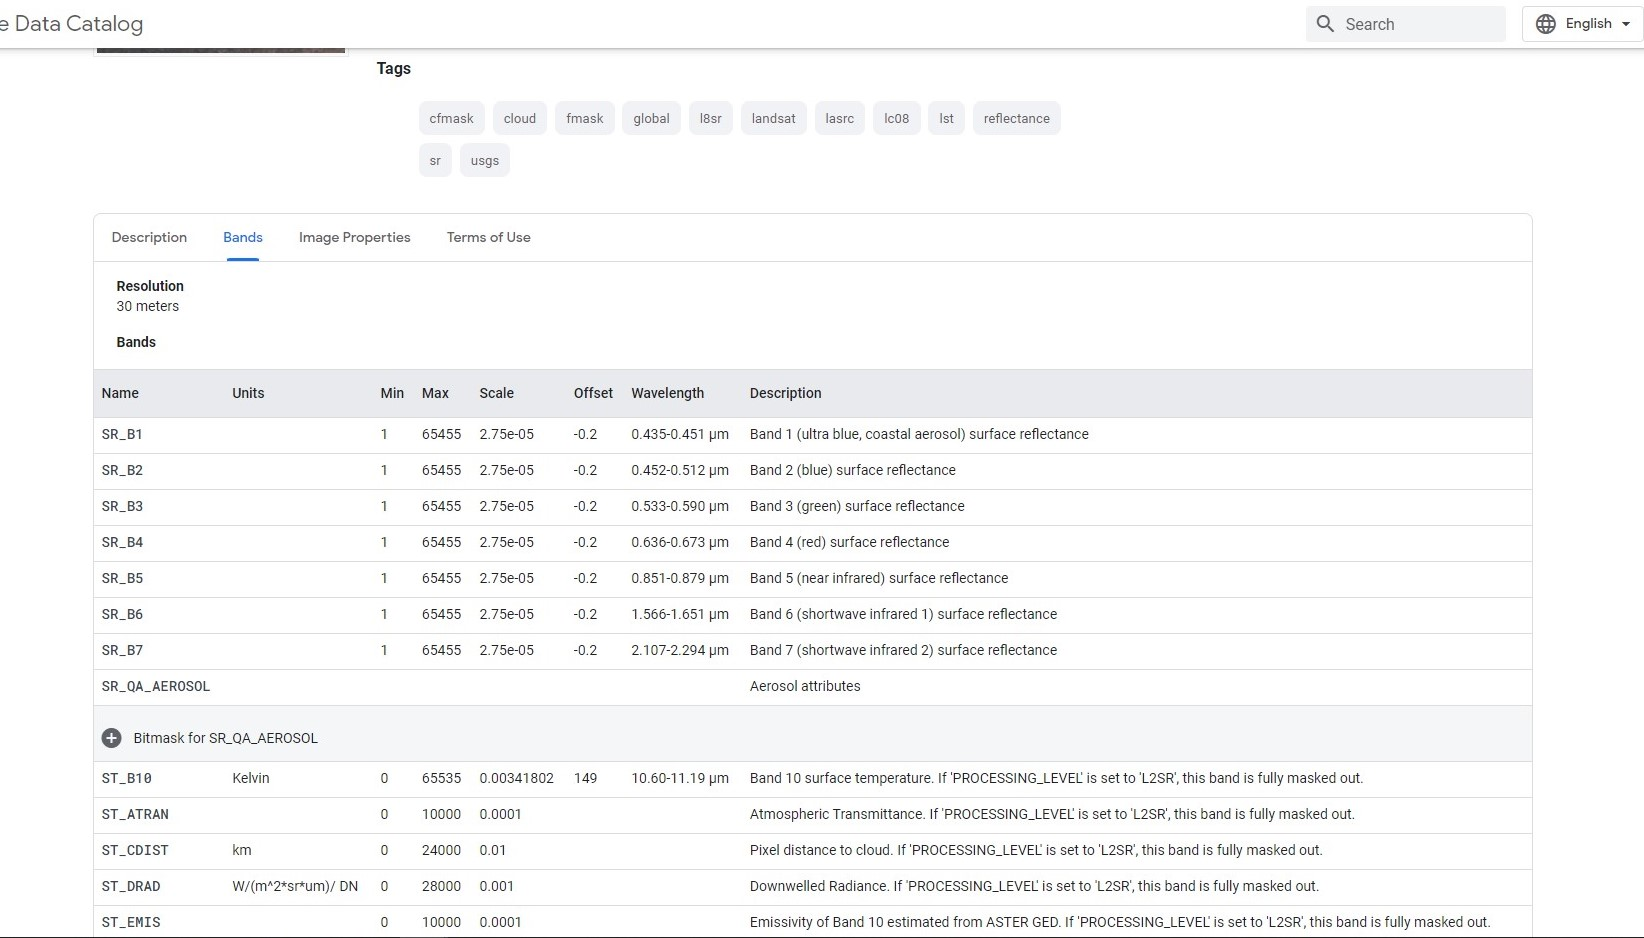

In [ ]:
org_im = ims.first()
t_startorg  = org_im.getInfo()['properties']['system:time_start']
print(datetime.utcfromtimestamp(t_startorg/1000.0).strftime('%Y-%m-%d %H:%M:%S'))
org_im = org_im.multiply(0.0000275).add(-0.2)

** 3. Make the display image with the same scale range

In [ ]:
im_clip = org_im.clip(aoi) #Clip to only in AOI
#To show image on a map, we need to build a visualization parameter first
viz_params = {'bands':['SR_B5','SR_B3','SR_B2'], 'min':min(minimum_im.values()), 
              'max': max(maximum_im.values())} 
rayong_map_obj = im_clip.getMapId(viz_params) # convert image into map object

## 4. Overlay on the map

In [ ]:
folium.TileLayer(
    tiles=rayong_map_obj['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Google Earth Engine',
    name='TOA Reflectance',
  ).add_to(rayong_map)
rayong_map